<h2>es04: Molecular Dynamics<h2>

<h5>4-1: include into the provided Molecular Dynamics code the possibility to restart from an old configuration, then use it to calibrate your system in order to achieve a desired temperature<h5>

The provided Molecular Dynamics code implements Verlet's algorithm, which only relies on the positions at time $t$ to compute those at time $t + dt$. The velocities can be then computed by discrete differentiation of the particles postitions. Since  the initial positions and velocities are set, the *kinetic and potential energy* are initially set; afterwards, the total energy is preserved, so the system undergoes a NVE evolution (particles number, volume and energy are bound to constant values). This means that the *temperature*, which is linked to kinetic energy alone, is not bound, and in fact it fluctuates widely until the system thermalizes. In fact, usually, the chosen start configuration is much more regular (maybe a chrystalline lattice, as for the solid system) than the thermical state that the system approaches in the end. Owing to this, a part of the initial system "kinetic energy" transforms into potential energy in order to increase disorder. 

Restart is a prerequisite for implementing an equilibration algorithm that progressively fixes temperature, by increasing (or decreasing) the initial velocities. 

First of all, ConfigFinal() method has been changed so that it also saves to file "old" coordinates:

    void ConfFinal(bool printinfo){ //Write final configuration
      ofstream WriteConf ("config.final");
      ofstream WriteOld("config.old");

      if(printinfo == true){
         cout << "Print final configuration to file config.final" << endl;
         cout << "Print old configuration to file config.old" << endl << endl;
      }

Then, a global bool variable "restart" was added, which influences the behaviour of Input() funtion: if false, it computes random initial velocities, if true, it computes velocities with the procedure described in LSN_Exercise04.
After that, in both cases velocities are multiplied by $\sqrt{3\frac{T}{<v^2>}}$

With this tools, a Calibrate() function was written, which first reads input, performs a custom number ("nsteps") of steps, updates a mean of instantaneous temperature estimates of the last nsteps/5 steps, and in the end checks whether the mean falls within the specified range from the target temperature: 

    void Calibrate (int nsteps, double discrepancy ){

Below are the data from the calibration loops:

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import myPythonModule as my
from itertools import islice

dirname = "exercices/output/dir04"
#picture of T during equilibration cycles
data = []

names = ["solid", "liquid","gas"]

solid
liquid
gas


IndexError: index 3 is out of bounds for axis 0 with size 3

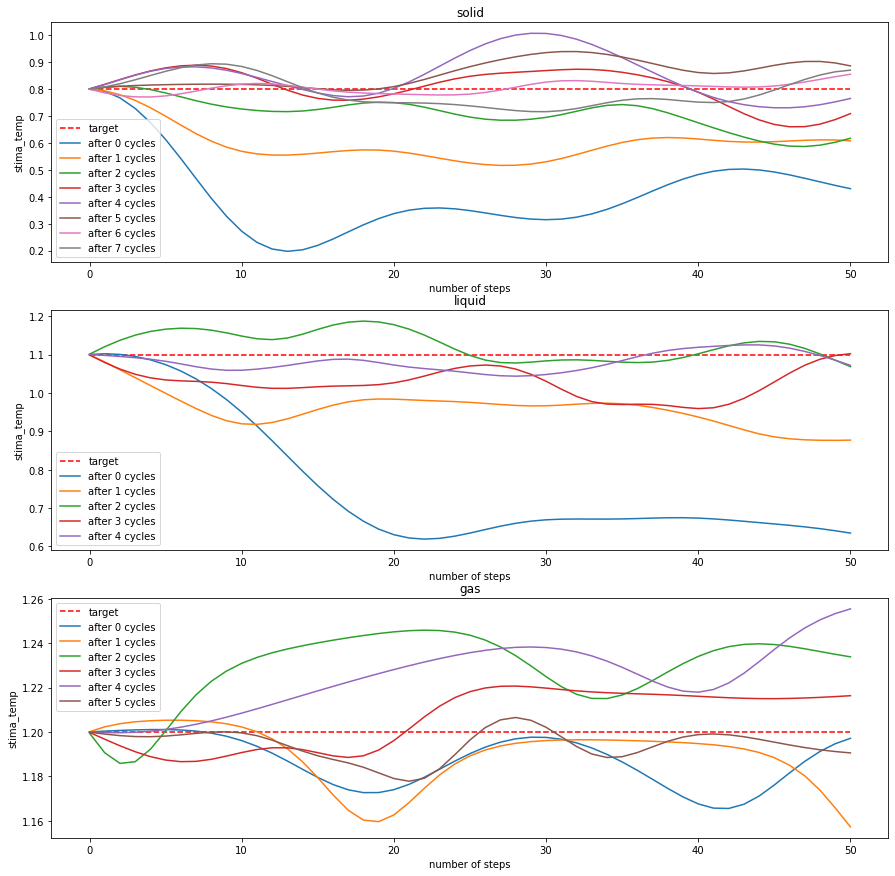

In [8]:

for name in names:
    data.append ([])
    print (name)
    with open (dirname + '/' + name + "/output_temp.dat") as f:
        #data = np.loadtxt (f, skiprows=1, max_rows=100, unpack=True)

        nForCycle = int (f.readline()) + 1
        while (True):
            line = f.readline ()

            if line == "End_Calibration\n":
                #print (line)
                break

            newdata = np.loadtxt (islice (f, nForCycle - 1), unpack=True)
            newdata = np.insert (newdata, 0, float (line))

            data[-1].append (newdata)
#print (data)
        
fig, ax = plt.subplots (3,1)
fig.set_size_inches( (15,15))

targetTemps = [0.8,1.1,1.2]

for ind, arrays in enumerate (data):
    x = range (arrays[0].shape[0])

    ax[ind].plot (x, targetTemps [ind] * np.ones(len(x)), label="target",linestyle='--', color='red')
    for ncycle , array in enumerate (arrays):
        ax[ind].plot (x, array, label=("after " + str(ncycle) + " cycles") )

    ax[ind].set_title (names[ind])
    ax[ind].set_xlabel ("number of steps")
    ax[ind].set_ylabel ("stima_temp")
    ax[ind].legend()
    
    
plt.show()


One can observe that every time a new cycle starts, the temperature jumps to exactly the target value. Every time the temperature drops due to equilibration between kinetic and potential energy; anyway, at the beginning of every cycle, the velocities ar multiplied by the scaling factor, thus effectively "warming" or "cooling" the sistem

<h5>4-2/3: implement block averaging and plot averages of thermodynamical quantities for the solid, liquid and gaseous phase of Argon<h5>

The block averaging was done via the BlockMean class defined in exercices/lib/tools.cpp aready used for exercise 3. For transormation to IS units a python class has been defined in myPythonModule.sh

In [9]:
def load_data (dirname):

    names = ["temp", "ekin", "epot", "etot", "press"]
    dataset = {
        names[0]:np.empty(0),
        names[1]:np.empty(0),
        names[2]:np.empty(0),
        names[3]:np.empty(0),
        names[4]:np.empty(0)
    }

    for name in names:
        filename = "output_" + name + ".dat"

        with open (dirname + '/' + filename) as file:
            skiplines = 0
            for nline, line in enumerate (file):
                if str (line) == "End_Calibration\n":
                    skiplines = nline
                    break
            #print (skiplines)

            dataset [name] = np.loadtxt (file, unpack=True, usecols=(1,2))
            
    return dataset

        
    

    

In [10]:


kb = 1.38064852e-23 #boltzmann constant
nA = 6.02214076e23 #avogadro number
epsilon = 120 * kb
sigma = 0.34*10**-9
m = 39.948 / nA / 1000 

conv = my.Converter( epsilon, sigma, m)


In [11]:
def plot_averages (name, conv: my.Converter): 
    dirname = "exercices/output/dir04/" + name
    dataset = load_data (dirname)


    fig, ax = plt.subplots (3,1)
    fig.set_size_inches (15,15)
    
    fig.suptitle (name, fontsize=16)


    x = range (dataset ["temp"].shape [1])



    ax[0].errorbar (x, dataset["temp"] [0] , dataset ["temp"] [1], label="temperature")
    #ax[0].errorbar (x, conv.convert (dataset["temp"] [0], "temp") , conv.convert (dataset ["temp"] [1], "temp"), label="temperature")
    ax[0].set_title ("Temperature, final value = {}".format(conv.convert(dataset["temp"][0][-1], "temp")))
    ax[0].set_ylabel ("T [K]")

    ax[1].errorbar (x, conv.convert (dataset["ekin"] [0], "E"), conv.convert (dataset ["ekin"] [1], "E"), label="kinetic energy")
    ax[1].errorbar (x, conv.convert (dataset["epot"] [0], "E"), conv.convert (dataset ["epot"] [1], "E"), label="potential energy")
    ax[1].errorbar (x, conv.convert (dataset["etot"] [0], "E"), conv.convert (dataset ["etot"] [1], "E"), label="total energy")
    ax[1].set_ylabel ("Energy [J]")
    ax[1].set_title ("Energies")

    ax[2].errorbar (x, conv.convert (dataset["press"] [0], "press", 10**-5), 
                     conv.convert (dataset ["press"] [1], "press" , 10**-5), label="pressure")
    ax[2].set_ylabel ("Pressure [Pa]")
    ax[2].set_title ("Pressure")



    for subplot in ax:
        subplot.set_xlabel ("number of blocks")
        subplot.legend()

    plt.show()


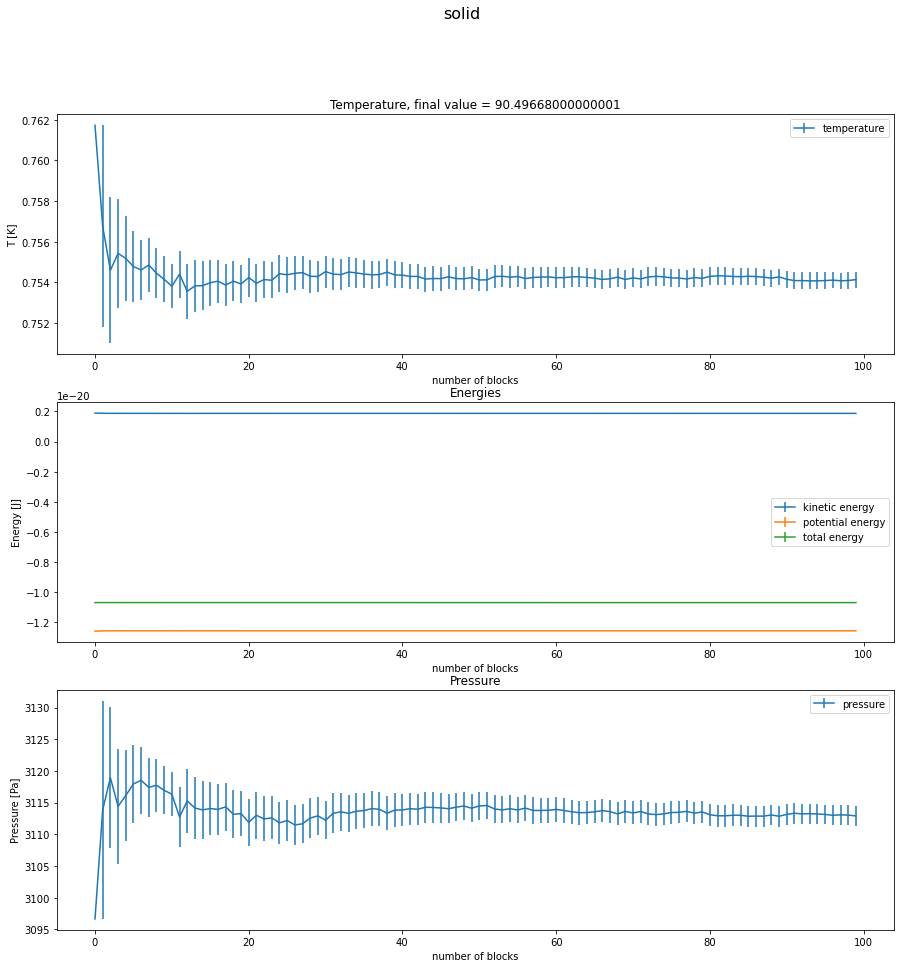

In [12]:
plot_averages ("solid", conv)

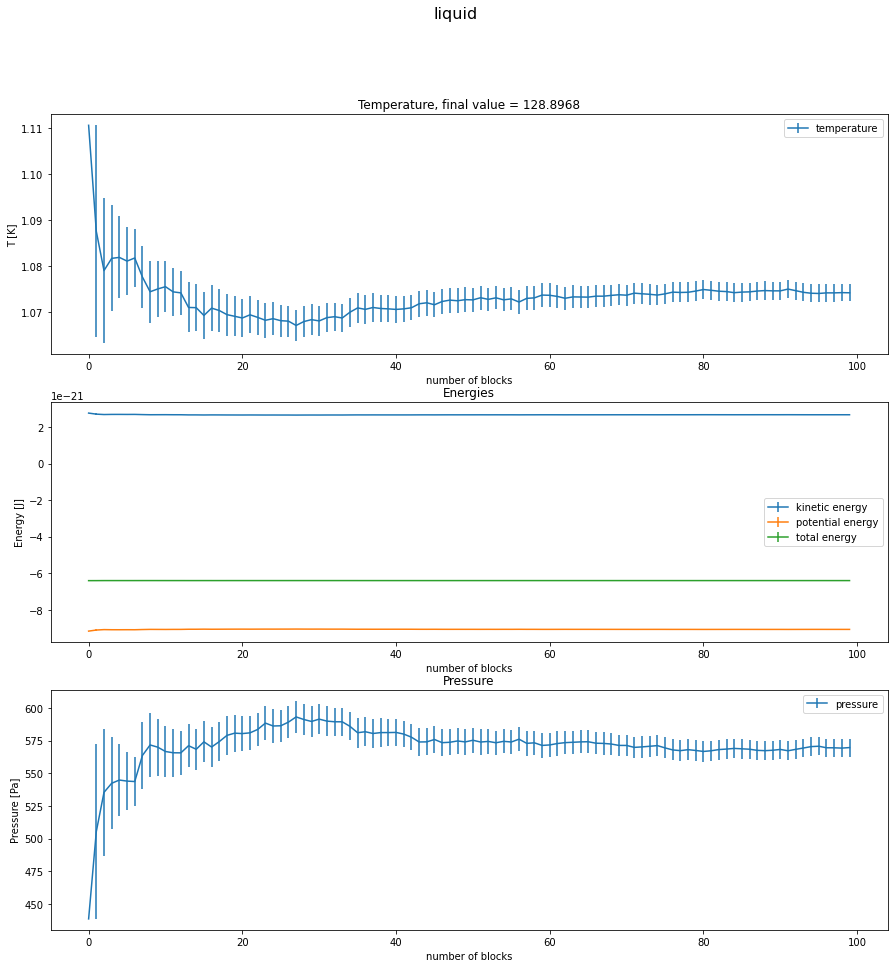

In [13]:
plot_averages ("liquid", conv)

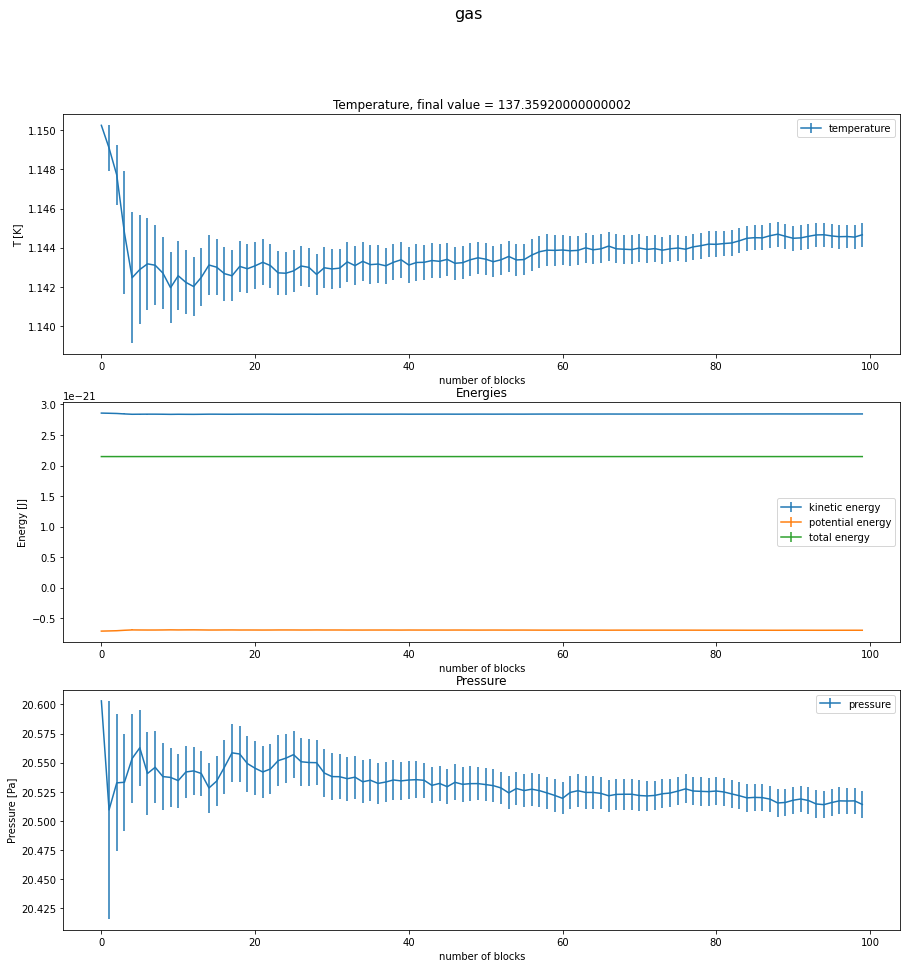

In [14]:
plot_averages ("gas", conv)

for comparison (data from [here](https://www.engineeringtoolbox.com/argon-d_1414.html)):
<ul>
    <li>Argon freezing point (1 atm pressure): -189 ° C = 84.5 ° K</li>
    <li>Argon boiling point (1 atm pressure): -186 ° C = 87.5 ° K </li>
</ul>

The comparison with data taken from experimental observation at constant pressure is not satisfactory, since it seems that, at the chosen temperatures, all of the three simulated systems should be in the gaseous phase. This is not the case, because the confination inside a fixed volume box makes a great difference in the behaviuor of the thermodynamical quantities.

Moreover, the pressure data are not consistent in theirselves: in fact, one should expect a monotonic increasing trend from solid to gas, for the bounds being, which is not observed. This may be due to not adding tail corrections.
